# Experiment description
## Hypothesis: 
We can train sepp model at city aggregation using three-weeks data

## Method: 

Train model using three-weeks data (2017-01-01 to 2017-01-22) at city scope. Try different parameters to achieve model convergence:
- Parameters configuration successful on experiment 04 (one week training)

## Results:
Hypothesis validated


In [1]:
%matplotlib inline
import pandas as pd
import pickle
import dateutil.parser
import pyproj
import open_cp
import open_cp.sepp as sepp
from PIL import Image
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import import_ipynb
import training_sepp_builtin

importing Jupyter notebook from training_sepp_builtin.ipynb
  Using cached https://github.com/QuantCrimAtLeeds/PredictCode/zipball/master
  Created wheel for opencp: filename=opencp-0.2.0-cp37-none-any.whl size=280058 sha256=7c88c4c41cbc177a1bababb9b4fed32e427e0cc0304a818381f67dacf7b94159
  Stored in directory: /tmp/pip-ephem-wheel-cache-apzaq6m3/wheels/9a/f6/1f/9ea8bd2ac044e7df5c432f658ba156f0cfc3540891a5bad62a
Successfully built opencp
  Using cached https://github.com/MatthewDaws/SEPP/zipball/master
  Created wheel for sepp: filename=sepp-0.9.0-cp37-none-any.whl size=37591 sha256=49c86fe0ce78eb247ad6e30e119899671c833368d5af078e6ac559f49a945aa0
  Stored in directory: /tmp/pip-ephem-wheel-cache-78_qvi0c/wheels/1d/e6/94/444aa295403d7f0e2ffd698d822abc6a4427daa85f8c5cb0b0
Successfully built sepp


Failed to load 'descartes' package.


In [3]:
def selectDataPrediction(nameLoc,dateIni,dateEnd):
    if nameLoc == 'city':
        dfloc = df
    else:
        dfloc = df[df["LOCALIDAD"]==nameLoc]
        
    dfloc = df[df["LOCALIDAD"]==nameLoc]
    dfloc["FECHA_HORA"]=dfloc["HORA"].astype(str)
    valHour = dfloc["FECHA_HORA"].values
    valDate = dfloc["FECHA"].values
    timesVals = [];
    k = 0;
    for i in valHour:
        if len(i)<=2:
            timeStr = valDate[k] +" " + "00:"+i+":00"
        else:
            timeStr = valDate[k] +" " + i[:-2]+":"+i[-2:]+":00"
        
        k = k + 1

        timesVals.append(timeStr)
    dfloc["FECHA_HORA"] = timesVals;
    
    dfloc["FECHA_HORA_TS"] = dfloc.FECHA_HORA.map(dateutil.parser.parse)
    dfFilter = dfloc[(dfloc.FECHA_HORA_TS > dateIni) & (dfloc.FECHA_HORA_TS < dateEnd)]
    timestamps = dfFilter.FECHA_HORA_TS
    
    print("TimeStamps")
    print(type(timestamps))

    xcoords, ycoords = (dfFilter.LONGITUD.values,dfFilter.LATITUD.values)
    proj = pyproj.Proj(init="EPSG:3116")
    xcoords, ycoords = proj(xcoords,ycoords)
    
    points_crime = open_cp.TimedPoints.from_coords(timestamps, xcoords, ycoords)
    
    #Generando Grilla para los algoritmos. 
    maxx = max(xcoords)
    minx = min(xcoords)
    maxy = max(ycoords)
    miny = min(ycoords)

    region = open_cp.RectangularRegion(xmin=minx, xmax=maxx, ymin=miny, ymax=maxy)
    
    return (points_crime,region)


In [4]:
def selectDataTraining(df,nameLoc,dateIni,dateEnd):
    if nameLoc == 'city':
        dfloc = df
    else:
        dfloc = df[df["LOCALIDAD"]==nameLoc]
        
    dfloc["FECHA_HORA"]=dfloc["HORA"].astype(str)
    valHour = dfloc["FECHA_HORA"].values
    valDate = dfloc["FECHA"].values
    timesVals = [];
    k = 0;
    for i in valHour:
        if len(i)<=2:
            timeStr = valDate[k] +" " + "00:"+i+":00"
        else:
            timeStr = valDate[k] +" " + i[:-2]+":"+i[-2:]+":00"
        
        k = k + 1

        timesVals.append(timeStr)
    dfloc["FECHA_HORA"] = timesVals;
    
    dfloc["FECHA_HORA_TS"] = dfloc.FECHA_HORA.map(dateutil.parser.parse)
    dfFilter = dfloc[(dfloc.FECHA_HORA_TS > dateIni) & (dfloc.FECHA_HORA_TS < dateEnd)]
    timestamps = dfFilter.FECHA_HORA_TS
    
    print("TimeStamps")
    print(type(timestamps))

    xcoords, ycoords = (dfFilter.LONGITUD.values,dfFilter.LATITUD.values)
    proj = pyproj.Proj(init="EPSG:3116")
    xcoords, ycoords = proj(xcoords,ycoords)
    
    points_train = open_cp.TimedPoints.from_coords(timestamps, xcoords, ycoords)
    return (points_train,timestamps,xcoords, ycoords)

In [5]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

def trainModel_parameters(df,nameLoc,dateIni,dateEnd,parameters,iterations=10):
    points_train,timestamps,xcoords, ycoords = selectDataTraining(df,nameLoc,dateIni,dateEnd)
    plt.scatter(xcoords, ycoords)
    print([timestamps])
    trainer = sepp.SEPPTrainer()
    trainer._initial_time_bandwidth = parameters['time_bw']
    trainer._initial_space_bandwidth = parameters['space_bw']
    trainer._time_cutoff = parameters['time_cutoff']
    trainer._space_cutoff = parameters['space_cutoff']
    print('time BW set on: ',trainer._initial_time_bandwidth)
    print('space BW set on: ',trainer._initial_space_bandwidth)
    print('time cutoff set on: ',trainer._time_cutoff)
    print('space cutoff set on: ',trainer._space_cutoff)
    print('Number of realizations: ',iterations)
    trainer.data = points_train    
    while True:  
        try:
            predictor = trainer.train()
            print("succesful training!")
            break
        except (RuntimeError, ValueError) as e:
            print(e)
            pass
        iterations = iterations - 1
        if iterations == 0:
            return "not succesfull training"
    return predictor 

In [6]:
def load_model(localidad, train_date):
    custom_path = path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+train_date+'.pkl'
    infile = open(custom_path,'rb')
    modelCrime = pickle.load(infile)
    infile.close()
    return modelCrime

In [7]:
def run_prediction(localidad,modelCrime,predict_time):
    points_crime,region = selectData(localidad,initial_date_prediction,final_date_prediction)
    modelCrime.data = points_crime 
    prediction = modelCrime.predict(predict_time)
    gridpred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_region(prediction, region, 150, 150)
    hitrates = open_cp.evaluation.hit_rates(gridpred, points_crime, [0.01,0.1])
    return gridpred, hitrates

In [8]:
def plot_gridpred(localidad,predict_time,gridpred):
    fig, ax = plt.subplots(figsize=(20,10))
    m = ax.pcolormesh(*gridpred.mesh_data(), gridpred.intensity_matrix, cmap="CMRmap_r")
    ax.set_title("Predicción localidad: "+localidad+'; fecha: '+str(predict_time))
    fig.colorbar(m, ax=ax)

## Select data

In [9]:
path = '/u01/user8/Documents/Riñas'

In [10]:
df = pd.read_csv(path+'/datasets/verify_enrich_nuse_29112019.csv')

In [11]:
initial_date = '2017-01-01'
final_date = '2017-01-22'

## Training experiments

### Scenario 1: successful parameters used on experiment 04
time_cutoff = [30, 50, 70, 90, 120]

#### Parameter = 30

In [12]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
700837   2017-01-21 13:06:00
700838   2017-01-21 14:16:00
700839   2017-01-21 17:30:00
700840   2017-01-21 10:56:00
700841   2017-01-21 14:41:00
Name: FECHA_HORA_TS, Length: 19834, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  30
space cutoff set on:  500
Number of realizations:  10
succesful training!


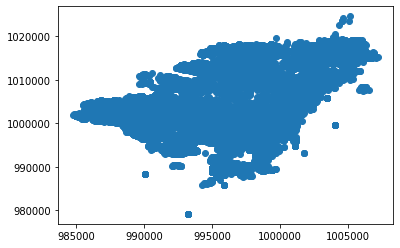

In [13]:
localidad = 'city'
parameters['time_cutoff'] = 30
iterations = 10
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters,iterations)
if city_predictor != "not succesfull training":    
    experiment_name = str(localidad)+'_'+initial_date+'_'+final_date+'_time_cutoff_'+str(parameters['time_cutoff'])
    city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+experiment_name+'.pkl','wb')
    pickle.dump(city_predictor, city_outfile)
    city_outfile.close() 

Results:
- Number of realizations: 1
- Average time elapsed for realization: 60 min
- No errors

#### Parameter = 50

In [14]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
700837   2017-01-21 13:06:00
700838   2017-01-21 14:16:00
700839   2017-01-21 17:30:00
700840   2017-01-21 10:56:00
700841   2017-01-21 14:41:00
Name: FECHA_HORA_TS, Length: 19834, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  50
space cutoff set on:  500
Number of realizations:  10
succesful training!


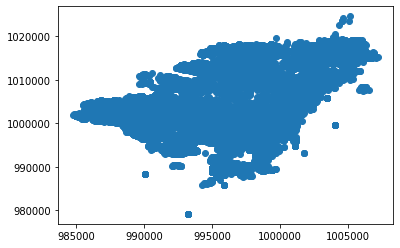

In [15]:
localidad = 'city'
parameters['time_cutoff'] = 50
iterations = 10
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters,iterations)
if city_predictor != "not succesfull training":    
    experiment_name = str(localidad)+'_'+initial_date+'_'+final_date+'_time_cutoff_'+str(parameters['time_cutoff'])
    city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+experiment_name+'.pkl','wb')
    pickle.dump(city_predictor, city_outfile)
    city_outfile.close() 

Results: 
- Number of realizations: 1
- Average time elapsed for realization: 60 min
- No errors

#### Parameter = 70

In [16]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
700837   2017-01-21 13:06:00
700838   2017-01-21 14:16:00
700839   2017-01-21 17:30:00
700840   2017-01-21 10:56:00
700841   2017-01-21 14:41:00
Name: FECHA_HORA_TS, Length: 19834, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  70
space cutoff set on:  500
Number of realizations:  10
succesful training!


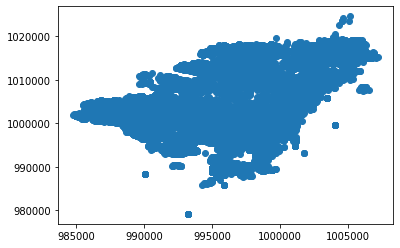

In [17]:
localidad = 'city'
parameters['time_cutoff'] = 70
iterations = 10
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters,iterations)
if city_predictor != "not succesfull training":    
    experiment_name = str(localidad)+'_'+initial_date+'_'+final_date+'_time_cutoff_'+str(parameters['time_cutoff'])
    city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+experiment_name+'.pkl','wb')
    pickle.dump(city_predictor, city_outfile)
    city_outfile.close() 

Results: 
- Number of realizations: 1
- Average time elapsed for realization: 60 min
- No errors

#### Parameter = 90

In [18]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
700837   2017-01-21 13:06:00
700838   2017-01-21 14:16:00
700839   2017-01-21 17:30:00
700840   2017-01-21 10:56:00
700841   2017-01-21 14:41:00
Name: FECHA_HORA_TS, Length: 19834, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  90
space cutoff set on:  500
Number of realizations:  10
succesful training!


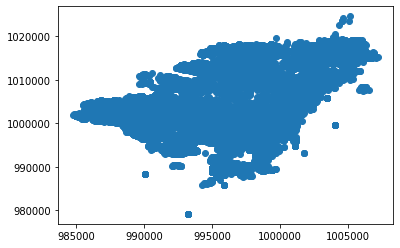

In [19]:
localidad = 'city'
parameters['time_cutoff'] = 90
iterations = 10
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters,iterations)
if city_predictor != "not succesfull training":    
    experiment_name = str(localidad)+'_'+initial_date+'_'+final_date+'_time_cutoff_'+str(parameters['time_cutoff'])
    city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+experiment_name+'.pkl','wb')
    pickle.dump(city_predictor, city_outfile)
    city_outfile.close() 

Results: 
- Number of realizations: 1
- Average time elapsed for realization: 60 min
- No errors